# Single electron S2 gain analysis

### Imports

In [1]:
# General definitions
%run '../definitions.ipynb'

# Specific to this analysis
%run 'definitions.ipynb'

/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


### Configuration

In [2]:
local_data = True

In [3]:
if local_data:
    processed_data_path = '/home/erik/win/data/xams_run8/processed/single_e_pmt/'
    minitree_path = '/home/erik/win/data/xams_run8/minitrees/'
else:
    processed_data_path = '/data/xenon/xams/run8/processed/data/'
    minitree_path = '/data/xenon/xams/run8/minitrees/'

In [4]:
run_names = ['170323_165324', # PMT1 950V, PMT2 1000V
             '170323_171247', '170323_173057', '170323_174120',  # PMT1 900 V, PMT2 950V
             '170324_074046', # PMT1 850V, PMT2 900V
             '170324_080005', # PMT1 1000V, PMT2 1000V 
             '170324_081950'  # PMT1 800V, PMT2 1000V
            ]
            

In [5]:
gains_set = [2.36e6, 0, 0, 2.28e6, 1e6, 0, 0, 0]
def get_gain(channels):
    '''
    Get the gain for a numpy array of channels
    '''
    if len(channels[(channels!=0) % (channels!=3)] > 0):
        print('Wait. What channels are you using? Why not 0 or 3?')
        print(channels[(channels!=0) % (channels!=3)])
    return 2.36e6 * (channels == 0) + 2.28e6 * (channels == 3)


def get_actual_area(d, gains_set, actual_gains):
    return ((d['area'] * d['area_fraction_top']) * gains_set[0] / actual_gains[0] +
     (d['area'] * (1 - d['area_fraction_top'])) * gains_set[3] / actual_gains[3] )

In [6]:
hax.init(
    # Always use these lines to tell hax that we don't care about Xe1T
    experiment='XAMS', 
    pax_version_policy='loose', use_runs_db = False,
    # Here come the useful settings
    main_data_paths = [processed_data_path, '/home/erik'],
    minitree_paths = [minitree_path],
#     use_root = False,
#     use_pickle = True
    # raw_data_local_path = raw_data_path         
         )

In [7]:
# Checklist previous paper
# - Basic event cuts
# - Time since main S2 cut
# - Width cut
# - Both PMTs contribute
# - (Average area of hits in peak)

## Analysis for first dataset

In [8]:
run_name = run_names[0]
stop_after = 10e3

### Event cuts

#### S1 and S2 threshold

In [9]:
d_events = hax.minitrees.load(run_name, 'Basics')

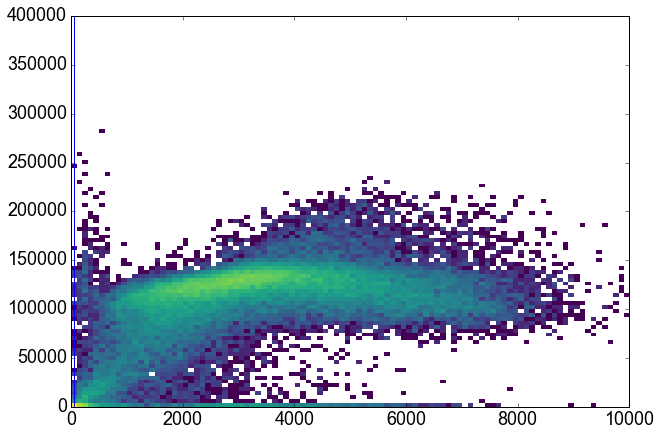

In [10]:
sel = np.invert(np.isnan(d_events['s1'])) & np.invert(np.isnan(d_events['s2']))
plt.hist2d(d_events[sel]['s1'], d_events[sel]['s2'], bins=100, norm=LogNorm(), range=((0, 10000), (0, 400e3)))
plt.axhline(200)
plt.axvline(50)
plt.show()

Cuts to make: S1 and S2 threshold. Let's put them at
s1 > 50 (note: not real p.e.!)
s2 > 200

### Peak cuts

In [11]:
# TODO nearest other peak!
# TODO decrease extension

In [12]:
d_peaks = hax.minitrees.load(run_name, ['Basics', XAMSPeaks], preselection= ['s1 > 50', 's2 > 200'])

/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/pandas/computation/align.py:98: RuntimeWarning: divide by zero encountered in log10
  ordm = np.log10(abs(reindexer_size - term_axis_size))


s1 > 50 selection: 7245 rows removed (93.53% passed)
s2 > 200 selection: 979 rows removed (99.06% passed)


In [13]:
d_peaks = add_s1s2_properties(d_peaks)

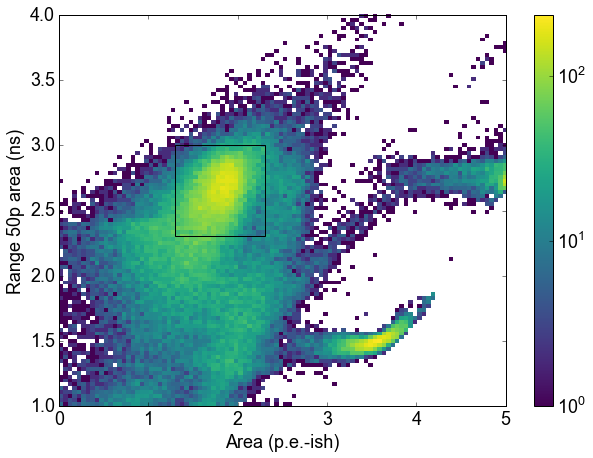

In [14]:
import matplotlib as mpl
area_bounds = (20, 200)
width_bounds = (200, 1000)

plt.hist2d(np.log10(d_peaks['area']), np.log10(d_peaks['range_50p_area']), bins=100,  norm=LogNorm(),
          #range=((0, 1000), (0, 5000)))
           range=((0, 5), (1, 4))
           )
draw_box(np.log10(area_bounds), np.log10(width_bounds))

plt.xlabel('Area (p.e.-ish)')
plt.ylabel('Range 50p area (ns)')
plt.colorbar()

In [18]:
d_peaks = cuts.range_selection(d_peaks, 'range_50p_area', width_bounds)
d_peaks = cuts.range_selection(d_peaks, 'area', area_bounds)

range_50p_area in [200, 1000) selection: 55995 rows removed (45.99% passed)
area in [20, 200) selection: 17261 rows removed (63.80% passed)


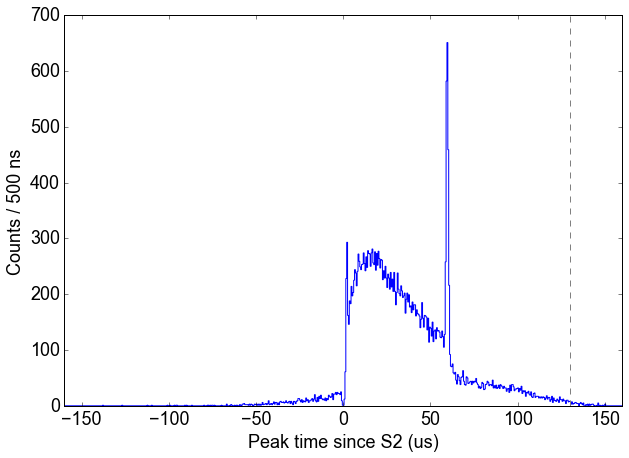

In [19]:
plt.hist(d_peaks['time_since_s2'] * 1e-3, bins=320 * 2, histtype='step', range=(-160, 160))
plt.axvline(10+ 2* 60, color='gray', ls='--')
plt.xlabel('Peak time since S2 (us)')
plt.ylabel('Counts / 500 ns')
plt.xlim(-160, 160)
plt.show()

### Hits

In [20]:
class XAMSHits(HitExtractor):
    __version__= '0.0.3'
    stop_after = 10e3
    peak_cut_list = ['detector == "tpc"', 'type !="lone_hit"', 
                     'range_50p_area > %f' % width_bounds[0],
                     'range_50p_area < %f' % width_bounds[1],
                     'area > %f' % area_bounds[0],
                     'area < %f' % area_bounds[1],
                    ]
    hit_fields = ['area', 'channel', 'height', 'right', 'left', 'sum_absolute_deviation', 'found_in_pulse']

In [21]:
d_hits = hax.minitrees.load(run_name, XAMSHits)

In [22]:
# Derived properties
d_hits['length'] = (d_hits['right'] - d_hits['left']) * 2

### Pulse

In [23]:
class XAMSPulses(PulseExtractor):
    __version__= '0.0.5'
    stop_after = stop_after
    df = d_hits
    pulse_properties = ['noise_sigma', 'n_hits_found', 'baseline', 'baseline_increase']

In [24]:
d_pulses = hax.minitrees.load(run_name, XAMSPulses)
# Combine all in hits dataframe
d_hits = pd.merge(d_hits, d_pulses, on=['event_number', 'found_in_pulse'], how='inner')


In [25]:
d_hits['sigmas'] = (d_hits['height'] / d_hits['noise_sigma'] * 50 * get_gain(d_hits['channel'].values)
                    * 16383 * 1.6022e-19 / 2e-9 / 2)
# The area in millions of electrons
d_hits['area_e'] = d_hits['area'] * get_gain(d_hits['channel'].values) * 1e-6

Wait. What channels are you using? Why not 0 or 3?
[0 0 0 ..., 0 0 0]
Wait. What channels are you using? Why not 0 or 3?
[0 0 0 ..., 0 0 0]


### Gain for one channel

In [26]:
channel = 0

In [27]:
_d = d_hits[d_hits['channel'] == channel]

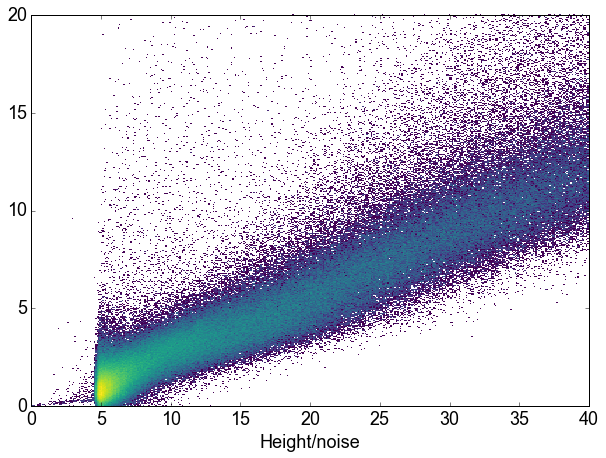

In [149]:
plt.hist2d(_d['sigmas'] , _d['area_e'], bins=400, norm=LogNorm(), 
           range=((0, 40), (0, 20)))
plt.xlabel('Height/noise')
plt.show()

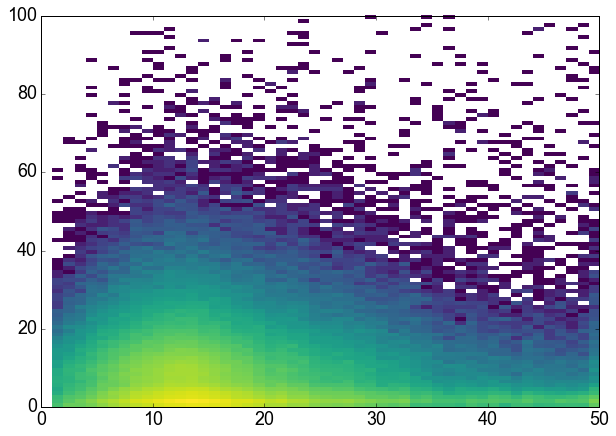

In [59]:
plt.hist2d(_d['n_hits_found'],_d['area_e']
           , bins=(50,100), range=((0, 50), (0,100)),norm=LogNorm())
plt.show()

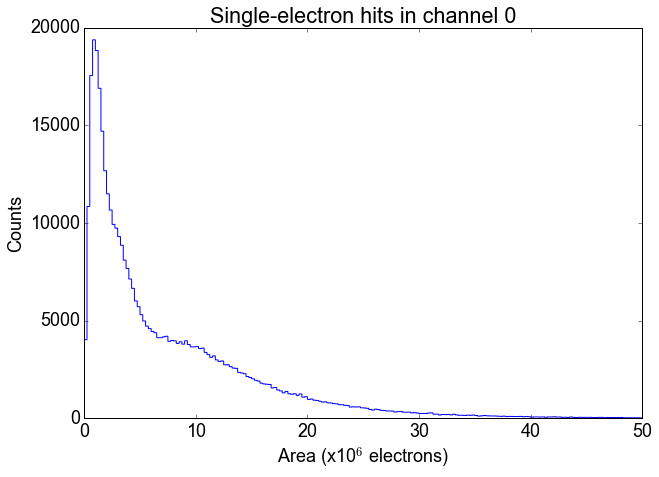

In [35]:
plt.hist(_d['area_e'], bins=200, histtype='step', range=(0,50))
plt.xlabel('Area (x10$^6$ electrons)')
plt.ylabel('Counts')
plt.title('Single-electron hits in channel %d' % channel)
plt.show()

### Read PMT calibration data

In [36]:
pmtcal_folder = '/data/xenon/xams/run8/processed/pmtdata/'
pmtcal_names = [
    '170323_101402', # 1000V
    '170323_102550' # 950 V
               ]

In [37]:
pmtcal_name = pmtcal_names[0]

In [38]:
store = pd.HDFStore(pmtcal_folder + pmtcal_name + '.hdf5')
data = store['all_hits']
_dcal = data[data['channel'] == channel]

In [39]:
_d_led = _dcal['area'].values * 1e-6

### Compare

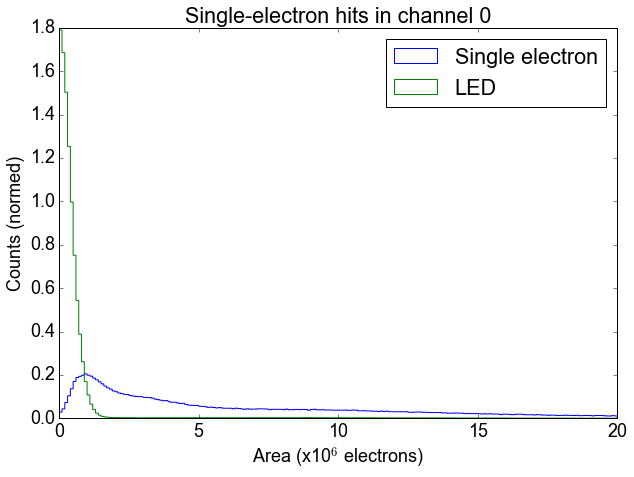

In [42]:
bins = 200
ran = (0,20)

counts,edges, _ = plt.hist(_d['area_e'], bins=bins, histtype='step', range=ran, normed=True, label='Single electron')

plt.hist(_d_led, bins=bins, histtype='step', range=ran, normed=True, label='LED')

plt.xlabel('Area (x10$^6$ electrons)')
plt.ylabel('Counts (normed)')
plt.title('Single-electron hits in channel %d' % channel)
plt.legend()
plt.show()

In [51]:
def hist_scale(d, scale=1, bins=100, range=(0,100), **kwargs):
    counts, edges = np.histogram(d, bins=bins, range=ran)
    centers = 0.5 * (edges[1:] + edges[:-1])
    plt.plot(centers, counts * scale, ls='steps', **kwargs)


(0, 1000)

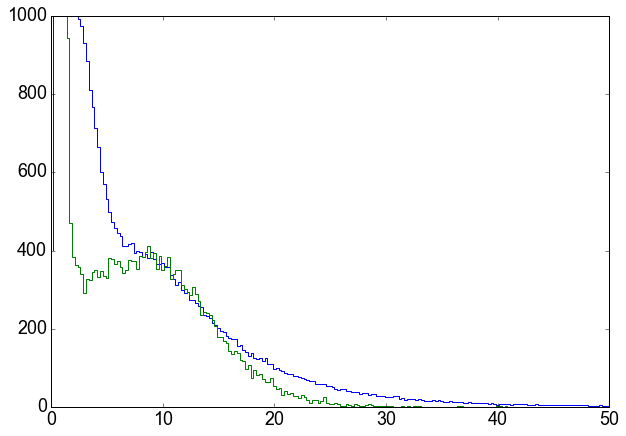

In [57]:
bins = 200
ran = (0,50)

hist_scale(_d['area_e'], bins=bins, range=ran, scale=0.1)
hist_scale(_d_led, bins=bins, range=ran, scale=1)
plt.ylim(0, 1000)

### Compare to normal-processed LED runs

In [ ]:
class XAMSHitsAll(HitExtractor):
    __version__= '0.0.0'
    hit_fields = ['area', 'channel', 'height', 'right', 'left', 'sum_absolute_deviation', 'found_in_pulse']

In [ ]:
bla = hax.minitrees.load('test_normal_processing_10k', [XAMSHitsAll, 'Fundamentals'])

In [ ]:
# Throw out the pulse channel
bla = bla[bla['channel'] != 4]

In [ ]:
# Take only channel 3
bla = bla[bla['channel'] ==3]

In [ ]:
bla['area_e'] = bla['area'] * get_gain(bla['channel'].values) * 1e-6

In [ ]:
bins = 200
ran = (0,20)

plt.hist(_d['area_e'], bins=bins, histtype='step', range=ran, normed=True, label='Single electron')
plt.hist(_d_led, bins=bins, histtype='step', range=ran, normed=True, label='LED')
plt.hist(bla['area_e'], bins=bins, histtype='step', range=ran, normed=True, label='LED 2.0')


plt.xlabel('Area (x10$^6$ electrons)')
plt.ylabel('Counts (normed)')
plt.title('Single-electron hits in channel %d' % channel)
plt.legend()
plt.show()

In [ ]:
# bad_events = [ev_n  for ev_n in np.unique(bla['event_number']) if sum(bla['event_number'] == ev_n) >= 5]
# sel = [ev_n not in bad_events for ev_n in bla['event_number']]
# bla = bla[sel]



In [ ]:
plt.hist(bla['left'], bins=100, range=(300, 400))
plt.show()

In [ ]:
bla = bla[(bla['left'] > 320) & (bla['left'] < 340)]

In [ ]:
bins = 200
ran = (0,20)

plt.hist(_d['area_e'], bins=bins, histtype='step', range=ran, normed=True, label='Single electron')
plt.hist(_d_led, bins=bins, histtype='step', range=ran, normed=True, label='LED')
plt.hist(bla['area_e'], bins=bins, histtype='step', range=ran, normed=True, label='LED 2.0')


plt.xlabel('Area (x10$^6$ electrons)')
plt.ylabel('Counts (normed)')
plt.title('Single-electron hits in channel %d' % channel)
plt.legend()
plt.show()

### Isolated hits

In [121]:
# d_hits[d_hits['event_number'] < 3][['channel', 'left', 'event_number', 'found_in_pulse']][29:]

In [111]:
def get_isolated_hits(d_hits, event_number, channel):
    ev = d_hits[(d_hits['event_number'] == event_number) & (d_hits['channel'] == channel)]

    right_previous_hit = np.insert(ev['right'].values[0:-1], 0, 0, axis=0)
    samples_between_previous_hit = ev['left'].values - right_previous_hit - 1

    left_next_hit = np.append(ev['left'].values[1:], 81909) # 81909 is max found
    samples_between_next_hit = left_next_hit - ev['right'].values - 1
    
    
    return ev[(samples_between_next_hit > 0) & (samples_between_previous_hit > 0)]
    

In [116]:
from tqdm import tqdm

In [136]:
l0 = []
for event_number in tqdm(np.unique(d_hits['event_number'])):
    l0.append(get_isolated_hits(d_hits, event_number, 0))

In [160]:
l3 = []
for event_number in tqdm(np.unique(d_hits['event_number'])):
    l3.append(get_isolated_hits(d_hits, event_number, 3))

In [161]:
import pandas as pd
d0 = pd.concat(l0)
d3 = pd.concat(l3)

In [139]:
len(d0)

115761

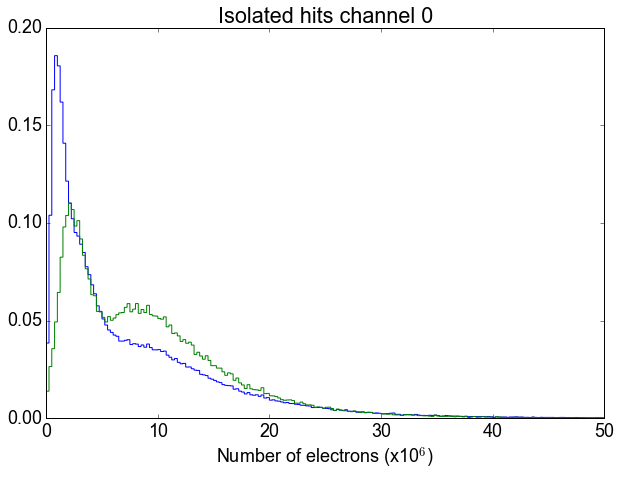

In [162]:
plt.hist(d_hits[d_hits['channel'] == 0]['area_e'], bins=bins, range=ran, histtype='step', normed=True)
plt.hist(d0['area_e'], bins=bins, range=ran, histtype='step', normed=True)
plt.xlabel('Number of electrons (x10$^6$)')
plt.title('Isolated hits channel 0')
plt.show()

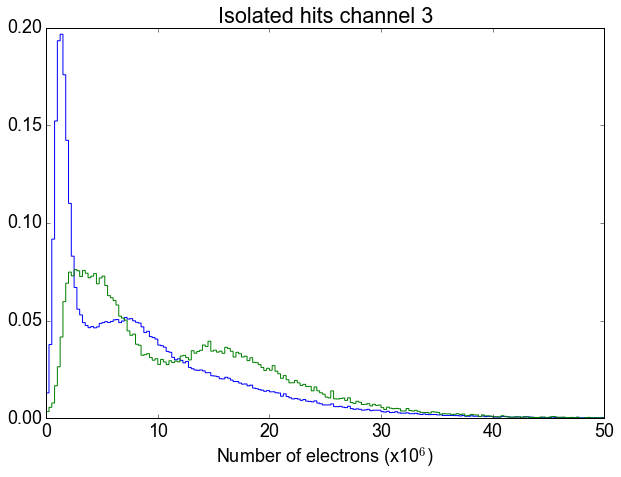

In [163]:
plt.hist(d_hits[d_hits['channel'] == 3]['area_e'], bins=bins, range=ran, histtype='step', normed=True)
plt.hist(d3['area_e'], bins=bins, range=ran, histtype='step', normed=True)
plt.xlabel('Number of electrons (x10$^6$)')
plt.title('Isolated hits channel 3')
plt.show()

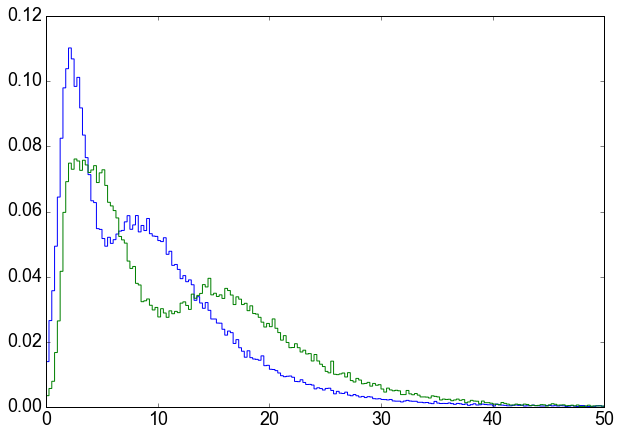

In [164]:
plt.hist(d0['area_e'], bins=bins, range=ran, histtype='step', normed=True)
plt.hist(d3['area_e'], bins=bins, range=ran, histtype='step', normed=True)
plt.show()

(0, 1000)

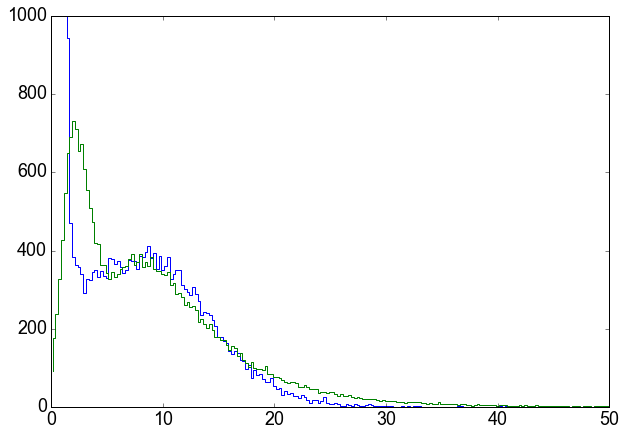

In [150]:
bins = 200
ran = (0,50)

#hist_scale(_d['area_e'], bins=bins, range=ran, scale=0.1)
hist_scale(_d_led, bins=bins, range=ran, scale=1)
hist_scale(d0['area_e'], bins=bins, range=ran, scale=0.23)
plt.ylim(0, 1000)

In [151]:
d0.keys()

Index(['area', 'channel', 'event_number', 'found_in_pulse', 'height', 'left',
       'right', 'run_number_x', 'sum_absolute_deviation', 'length', 'baseline',
       'baseline_increase', 'n_hits_found', 'noise_sigma', 'run_number_y',
       'sigmas', 'area_e'],
      dtype='object')

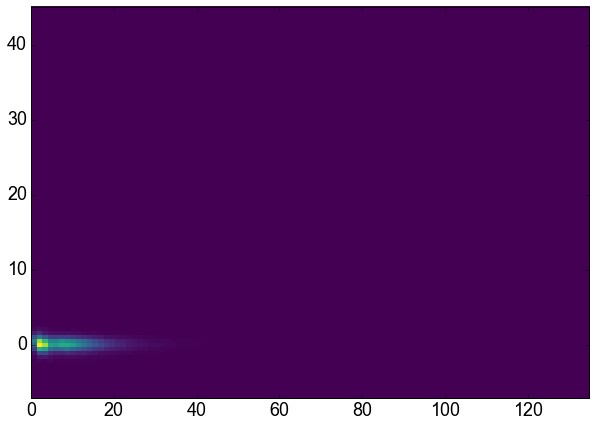

In [157]:
plt.hist2d(d0['area_e'], d0['baseline_increase'], bins=100)
plt.show()